In [17]:
from collections import Counter
from keras.preprocessing.text import Tokenizer
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import precision_score 
from sklearn.metrics import recall_score 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import make_scorer
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm import tqdm
import sys
import os
import json 
import random
import glob
import pandas as pd
import pickle
import numpy as np
from pprint import pprint,pformat
from metricUtils import tn, fp, tp, fn, precision, recall, fpr, tpr, tnr, f1, auc, mcc
import seaborn as sn
import matplotlib.pyplot as plt
from itertools import product

In [2]:
# Define Test smells
TEST_SMELLS=['AssertionRoulette', 'ConditionalTestLogic',
       'ConstructorInitialization', 'DefaultTest', 'DuplicateAssertion',
       'EmptyTest', 'ExceptionHandling', 'GeneralFixture', 'IgnoredTest',
       'LackCohesion', 'MagicNumberTest', 'ObscureInLineSetup',
       'RedundantAssertion', 'RedundantPrint', 'SleepyTest',
       'SuboptimalAssert', 'TestMaverick', 'UnknownTest']

In [3]:
# Read oracle data
data=pd.read_csv('../data/oracle/oracle.csv')
data.columns

Index(['Unnamed: 0', 'repo_name', 'file_name', 'class_name', 'func_name',
       'AssertionRoulette', 'ConditionalTestLogic',
       'ConstructorInitialization', 'DefaultTest', 'DuplicateAssertion',
       'EmptyTest', 'ExceptionHandling', 'GeneralFixture', 'IgnoredTest',
       'LackCohesion', 'MagicNumberTest', 'ObscureInLineSetup',
       'RedundantAssertion', 'RedundantPrint', 'SleepyTest',
       'SuboptimalAssert', 'TestMaverick', 'UnknownTest', 'body', 'voc_size',
       'important_voc', 'flaky'],
      dtype='object')

In [5]:
np.random.seed(0)

# Establish the configurations for the experiment
num_folds = [5, 10]
num_trees = [100, 200]
modes = ["binary", "count", "tfidf", "freq"]
num_words =[100, 2000]
lower_states =[True, False]

# get all combinations of the configurations
configurations = list(product(num_folds, num_trees, modes, num_words, lower_states))

# build a progress bar
progress_bar = tqdm(configurations)

final_scores = []

for config in progress_bar:
    folds, trees, mode, words, lower_state = config
    progress_bar.set_description(f'{folds}, {trees}, {mode}, {words}, {lower_state}')

    # Shuffle Data
    data = shuffle(data, random_state=0)
    
    #extract test smells
    data_test_smell=data[TEST_SMELLS]

    # Building Tokenizer and Vocabulary
    body = data['body'].values
    tokenizer = Tokenizer(lower=lower_state, num_words=words, filters='\'!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
    tokenizer.fit_on_texts(body)
    TK = tokenizer.texts_to_matrix(body, mode=mode)
    TK_df = pd.DataFrame(data=TK)
    X=pd.concat([data_test_smell, TK_df], axis=1)
#     X = TK_df
    y_true = data['flaky'].values

    # Random Forest Model
    rf = RandomForestClassifier(n_estimators = trees, random_state = 0) 
   
    y_pred = cross_val_predict(rf, X, y_true, cv=folds, verbose=0, n_jobs=-1)
    precision, recall, f1_score, support = precision_recall_fscore_support(y_true, y_pred, average='macro')
    
#     matrix = confusion_matrix(y_true, y_pred)
#     print(matrix)
#     print(precision, recall, f1_score, support)
    
    # Save score
    o = {
        "variables": {
            "num_folds": folds,
            "num_trees": trees,
            "mode": mode,
            "num_words": words,
            "lower_state": lower_state

        },
        "Precision": precision,
        "Recall": recall,
        "F1": f1_score,
        "support": support
    }
    final_scores.append(o)


# Display final scores
sorted_scores = sorted(final_scores, key=lambda x: x["F1"], reverse=True)

# Best / Worst config
print("\nBest configuration:")
pprint(sorted_scores[0])
print("\nWorst configuration:")
pprint(sorted_scores[-1])

10, 200, freq, 2000, False: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [03:45<00:00,  3.53s/it]


Best configuration:
{'F1': 0.9583634689336542,
 'Precision': 0.9968285610728524,
 'Recall': 0.9258474576271186,
 'support': None,
 'variables': {'lower_state': True,
               'mode': 'binary',
               'num_folds': 5,
               'num_trees': 200,
               'num_words': 2000}}

Worst configuration:
{'F1': 0.9349464356041461,
 'Precision': 0.9900428619485657,
 'Recall': 0.8917667706346581,
 'support': None,
 'variables': {'lower_state': True,
               'mode': 'freq',
               'num_folds': 5,
               'num_trees': 200,
               'num_words': 100}}


Best configuration for voc model:
{'F1': 0.9598179007753476,
 'Precision': 0.9945571791726664,
 'Recall': 0.9299935548088545,
 'support': None,
 'variables': {'lower_state': False,
               'mode': 'count',
               'num_folds': 10,
               'num_trees': 100,
               'num_words': 2000}}

Best configuration:
{'F1': 0.9583634689336542,
 'Precision': 0.9968285610728524,
 'Recall': 0.9258474576271186,
 'support': None,
 'variables': {'lower_state': True,
               'mode': 'binary',
               'num_folds': 5,
               'num_trees': 200,
               'num_words': 2000}}

In [18]:
# create the best combined appraoch model
body = data['body'].values
tokenizer = Tokenizer(lower=True, num_words=2000, filters='\'!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(body)
TK = tokenizer.texts_to_matrix(body, mode='binary')
TK_df = pd.DataFrame(data=TK)
X=pd.concat([data_test_smell, TK_df], axis=1)
y_true = data['flaky'].values

combined_model_best_rf = RandomForestClassifier(n_estimators=200, random_state = 0).fit(X, y_true)

c:\users\q0ha\documents\repos\soen7481_project\venv\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [19]:
# Evaluate the best combined appraoch model
# feature_importances = pd.DataFrame(combined_model_best_rf.feature_importances_, index =X.columns,  columns=['importance']).sort_values('importance', ascending=False)
y_pred = cross_val_predict(combined_model_best_rf, X, y_true, cv=folds, verbose=0, n_jobs=-1)

# combined_model_best_rf.feature_importances_

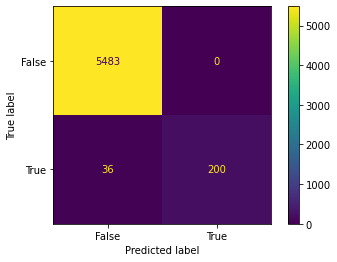

In [22]:
ConfusionMatrixDisplay.from_predictions(y_true, y_pred)